### Loading the datasets to be used



In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()


claims = pd.read_csv("data/project_udacity_blogspot_claims.csv", parse_dates=['date_treatment','date_claim_finalized'])
savings = pd.read_csv("data/project_udacity_blogspot_savings.csv", parse_dates=['transaction_date'])

savings.head()


,account_id,gender_of_saver,transaction_date,transaction_type,amount,family_size,age
0,1677286,MALE,2018-01-25 23:54:51,SavingVirtual,50,1,50
1,2352760,MALE,2018-01-26 00:02:18,SavingVirtual,100,1,31
2,1000896,MALE,2018-01-26 00:22:07,SavingVirtual,100,1,25
3,1954110,MALE,2018-01-26 01:36:18,SavingVirtual,100,1,56
4,2102400,MALE,2018-01-26 02:59:46,SavingVirtual,50,2,57


### Profiling the columns in the datasets

In [24]:
claims.describe(include='all')

,treatment_id,provider_name,sub_region,region,date_treatment,claim_status,claim_amount,date_claim_finalized
count,63645.000000,63645,63288,63288,63197,63645,6.364400e+04,38332
unique,NaN,704,139,32,63115,7,NaN,38319
top,NaN,Nakuru Maternity and Nursing Home,KISUMU-CENTRAL,NAIROBI,2017-02-11 11:47:31,Approved,NaN,2019-01-18 13:59:44
freq,NaN,5811,10571,25653,3,36340,NaN,2
first,NaN,NaN,NaN,NaN,2016-05-19 09:57:40,NaN,NaN,2016-05-19 20:18:35
last,NaN,NaN,NaN,NaN,2020-09-30 13:54:37,NaN,NaN,2020-10-01 16:32:45
mean,314344.104957,NaN,NaN,NaN,NaN,NaN,1.121626e+03,NaN
std,184837.449693,NaN,NaN,NaN,NaN,NaN,2.183019e+05,NaN
min,19678.000000,NaN,NaN,NaN,NaN,NaN,-1.200000e+04,NaN
25%,177882.000000,NaN,NaN,NaN,NaN,NaN,0.000000e+00,NaN


In [25]:
savings.describe(include='all')

,account_id,gender_of_saver,transaction_date,transaction_type,amount,family_size,age
count,5.897020e+05,589702,589702,589702,589702.00000,589702.000000,589702.000000
unique,NaN,2,578319,2,NaN,NaN,NaN
top,NaN,MALE,2018-01-20 13:00:00,SavingVirtual,NaN,NaN,NaN
freq,NaN,361768,337,560969,NaN,NaN,NaN
first,NaN,NaN,2016-05-19 00:57:59,NaN,NaN,NaN,NaN
last,NaN,NaN,2020-09-30 21:51:29,NaN,NaN,NaN,NaN
mean,2.423187e+06,NaN,NaN,NaN,109.49185,1.596284,38.104224
std,2.267083e+06,NaN,NaN,NaN,324.57837,8.682627,15.767719
min,1.371700e+04,NaN,NaN,NaN,1.00000,1.000000,2.000000
25%,9.543360e+05,NaN,NaN,NaN,40.00000,1.000000,29.000000


### User defined functions  to  be  used

In [26]:
def remove_zero_negative_amount(amount):
    """removes negative amount"""

    return amount if amount > 0 else np.nan

In [27]:
def remove_anomolous_ages(age, max_age=130):
    """remove anomolously ages under 18 or over 130"""

    return age if (age >= 18 and age < max_age) else None

In [28]:
def get_amt_buckets(series, bins=(100, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000)):
    """divide into amount buckets according to left closed, right open bins"""

    bins = sorted(bins)

    if bins[0] != 0:
        bins = [0] + bins

    max_amt = max(series)
    if max_amt > bins[-1]:
        bins = bins + [max_amt + 1]

    amt_buckets = pd.cut(series, bins=bins, precision=0, right=False)
    
    def string_rep(interval):
        '''represent right open interval as a right and left closed interval without bracket notation

        Example: [0-10) goes to "0-9"'''

        left = interval.left
        right = interval.right - 1

        return "{0}-{1}".format(left, right)

    amt_buckets = amt_buckets.apply(string_rep).astype(object)

    return amt_buckets


In [29]:

def aggregate_claims_month(df):
    """aggregate claims dataset by month"""

    agg_dict = {
        "treatment_id": "count",
        "claim_amount": "sum",

    }

    rename_dict = {
        "claim_amount": "monthly_claim_amount",
        "treatment_id": "n_treatments",
    }


    df_agg = df.groupby("month_finalized").agg(agg_dict)
    df_agg['claim_amount']/ 10 ** 6
    df_agg = df_agg.rename(rename_dict, axis=1)
    
    
    return df_agg

In [30]:
def calculate_percentage(column_name):
    """calculate a percentage column for a numerical column in a dataframe"""
    return round(column_name / column_name.sum() * 100, 2)



In [31]:
def calculate_cumulative_percentage(column_name):
    """calculate a percentage column for a numerical column in a dataframe"""
    return round(column_name.cumsum() / column_name.sum() * 100, 2)

In [32]:
def get_age_groups(series, bins=(18, 30, 40, 50, 60, 70, 80, 90, 100)):
    """divide into age buckets according to left closed, right open bins"""

    bins = sorted(bins)

    if bins[0] != 0:
        bins = [0] + bins

    max_age = max(series)
    if max_age > bins[-1]:
        bins = bins + [max_age + 1]

    age_buckets = pd.cut(series, bins=bins, right=False, precision = 0)
    
    def string_rep(interval):
        '''represent right open interval as a right and left closed interval without bracket notation

        Example: [0-10) goes to "0-9"'''

        left = interval.left
        right = interval.right - 1

        return "{0}-{1}".format(left, right)

    age_buckets = age_buckets.apply(string_rep).astype(object)

    return age_buckets

# Claims Analysis


### Cleaning and preprocessing data set

In [33]:
claims = pd.read_csv("data/project_udacity_blogspot_claims.csv", parse_dates=['date_treatment','date_claim_finalized'])

In [34]:
#Remove Draft & Deleted claims AND claims from Test clinic 
status_omit = ['Deleted', 'Draft']  

claims = claims[(~ claims['claim_status'].isin(status_omit)) & (claims['provider_name'] != 'MTIBA Clinic') & (claims['claim_amount'].notnull())] 



In [35]:
#Remove zero & negative amounts
claims['claim_amount'] = claims['claim_amount'].apply(remove_zero_negative_amount)

In [36]:
#Remove NULL amounts
claims = claims[claims.claim_amount.notna()]


#convert 'claim amount' from float to int
claims['claim_amount'] = claims['claim_amount'].astype(np.int64)

In [37]:
#Claim Amount Buckets

claims["claim_amt_bucket"] = get_amt_buckets(claims["claim_amount"])

In [45]:
#Arranging claim amount buckets chronologically
claim_buckets = ["0-99", "100-499", "500-999", "1000-1499", "1500-1999", "2000-2499", "2500-2999", "3000-3499", "3500-3999", "4000-4499", "4500-4999", "5000-43700"]

#Assigning categories
claims.claim_amt_bucket = pd.Categorical(claims.claim_amt_bucket ,categories=claim_buckets, ordered = True)


#### Claim Buckets Distribution

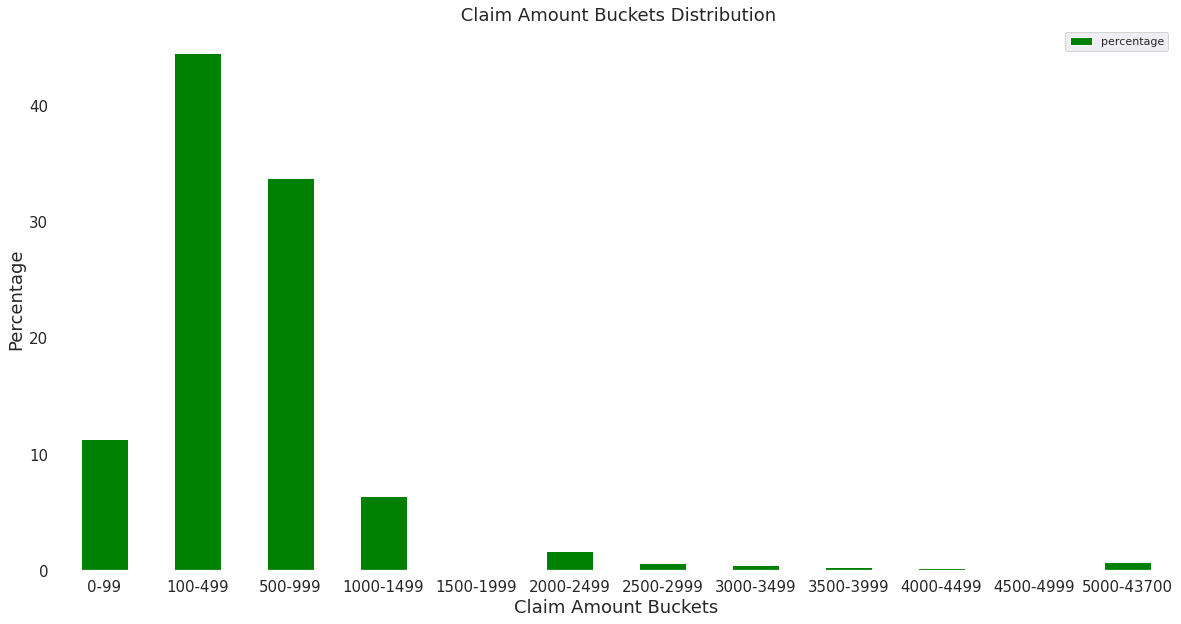

In [48]:

count_by_claim_bucket = claims.groupby("claim_amt_bucket")["treatment_id"].count().reset_index().rename(
    columns = {"treatment_id" : "count"})


count_by_claim_bucket['percentage'] = calculate_percentage(count_by_claim_bucket["count"])




plt = count_by_claim_bucket.plot(kind = "bar", x = "claim_amt_bucket", y = "percentage", figsize = (20,10), 
                           rot=0, fontsize = 15, color = "green")
plt.set_title(" Claim Amount Buckets Distribution", fontsize = 18)
plt.set_xlabel("Claim Amount Buckets", fontsize = 18)
plt.set_ylabel("Percentage", fontsize = 18)
plt.set_facecolor("white");

plt.figure.savefig("plots/count_by_claim_bucket.png", dpi = 300)

#### Typical Claim Amount


In [110]:
#To get median of claim_amount of the dataset
claims.claim_amount.describe()

count    23455.000000
mean       587.673033
std       1195.474218
min          1.000000
25%        150.000000
50%        400.000000
75%        650.000000
max      43700.000000
Name: claim_amount, dtype: float64

#### Cumulative amount paid out to providers for MHF over the months 

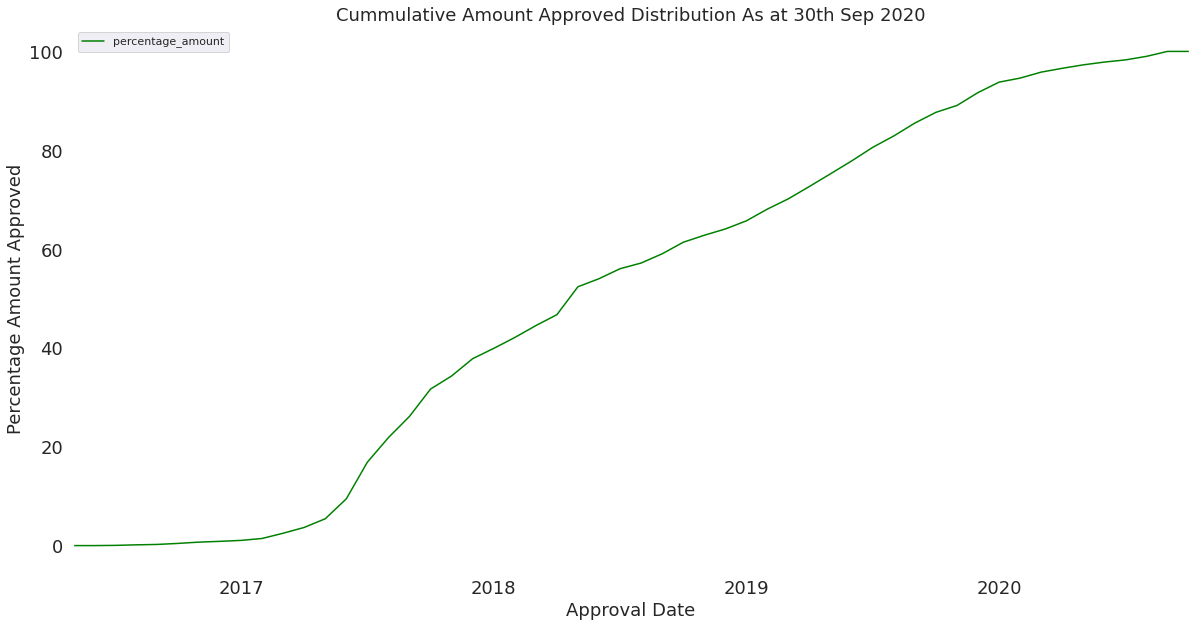

In [125]:
#Introduce a month- year column for when the claim was finalized
claims['month_finalized'] = claims['date_claim_finalized'].dt.to_period('M')

#Get Only Approved claims
approved_claims = claims[claims['claim_status']== 'Approved']


#Get Aggregated  dataframe over Months
summarized_approved = aggregate_claims_month(approved_claims)


#Get cummulative percentage amount
summarized_approved['percentage_amount'] = calculate_cumulative_percentage(summarized_approved['monthly_claim_amount'])


#Plotting

plt = summarized_approved.reset_index().plot(kind = 'line', x = 'month_finalized', y = 'percentage_amount', 
                                   figsize = (20,10), color = "green", fontsize = 18);
plt.set_title("Cummulative Amount Approved Distribution As at 30th Sep 2020", fontsize = 18)
plt.set_xlabel("Approval Date", fontsize = 18)
plt.set_ylabel("Percentage Amount Approved", fontsize = 18)
plt.set_facecolor("white");


plt.figure.savefig('plots/summarized_approved.png', dpi=300 )

#### Distribution of claims by Top Counties

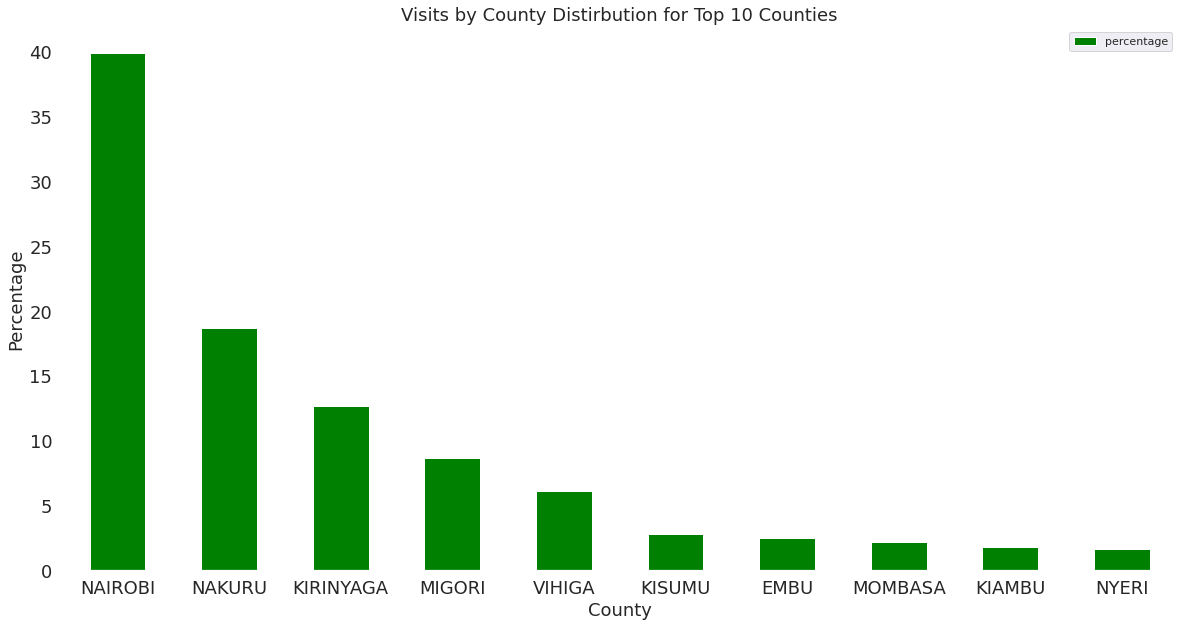

In [127]:
count_by_region = claims.groupby("region")["treatment_id"].count().reset_index().rename(
    columns = {"treatment_id" : "count"}).sort_values(
    "count",ascending = False)

count_by_region['percentage'] = calculate_percentage(count_by_region["count"])


#pick top 10
count_by_region = count_by_region.head(10)


plt = count_by_region.plot(kind = "bar", x = "region", y = "percentage", figsize = (20,10), 
                           rot=0, fontsize = 18, color = "green")

plt.set_title("Visits by County Distirbution for Top 10 Counties", fontsize = 18)
plt.set_xlabel("County", fontsize = 18)
plt.set_ylabel("Percentage", fontsize = 18)
plt.set_facecolor("white");


plt.figure.savefig('plots/count_by_region.png', dpi = 100 )


# Savings Analysis

#### Cleaning and preprocessing data set

In [129]:
#Remove negative amounts
savings['amount'] = savings['amount'].apply(remove_negative_amount)

In [130]:
#Remove anomolous ages
savings['age'] = savings['age'].apply(remove_anomolous_ages)

#Remove NULL Age
savings = savings[savings.age.notna()]


#convert 'age' from float to int
savings['age'] = savings['age'].astype(np.int64)


In [131]:
#assigning age buckets to age column
savings["age_buckets"] = get_age_groups(savings["age"])

In [132]:
#Assigning Day of week Transaction happened
savings['weekday_saved'] = savings['transaction_date'].dt.day_name()

#Arranging weekdays chronologically
weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

#Assigning categories
savings.weekday_saved = pd.Categorical(savings.weekday_saved ,categories=weekdays, ordered = True)



#Assigning Month of Year Transaction happened
savings['month_saved'] = savings['transaction_date'].dt.month_name()

In [133]:
#Derivng month and year saving event happened
savings['month_saved'] = savings['transaction_date'].dt.to_period('M')

In [134]:
#Savings Dataset
savings_data = savings[savings['transaction_type'] == 'SavingVirtual']


#Remittance Dataset
remittance_data = savings[savings['transaction_type'] == 'RemittanceVirtual']

#### Typical Amount Saved by a member and Amount Remitted to a member

In [135]:

#Median
median = savings.groupby('transaction_type')['amount'].median()
median


#Mean
mean = savings.groupby('transaction_type')['amount'].mean()

print(median) 

print(mean)



transaction_type
RemittanceVirtual    100
SavingVirtual        100
Name: amount, dtype: int64
transaction_type
RemittanceVirtual    129.303877
SavingVirtual        108.474503
Name: amount, dtype: float64


#### Distribution of Savings over Week Day

In [177]:

#No of transactions by day of week
no_savings_by_weekday = savings_data.groupby('weekday_saved').size().to_frame('size')

#Amount saved by day of week
amount_savings_by_weekday = savings_data.groupby('weekday_saved')['amount'].sum()

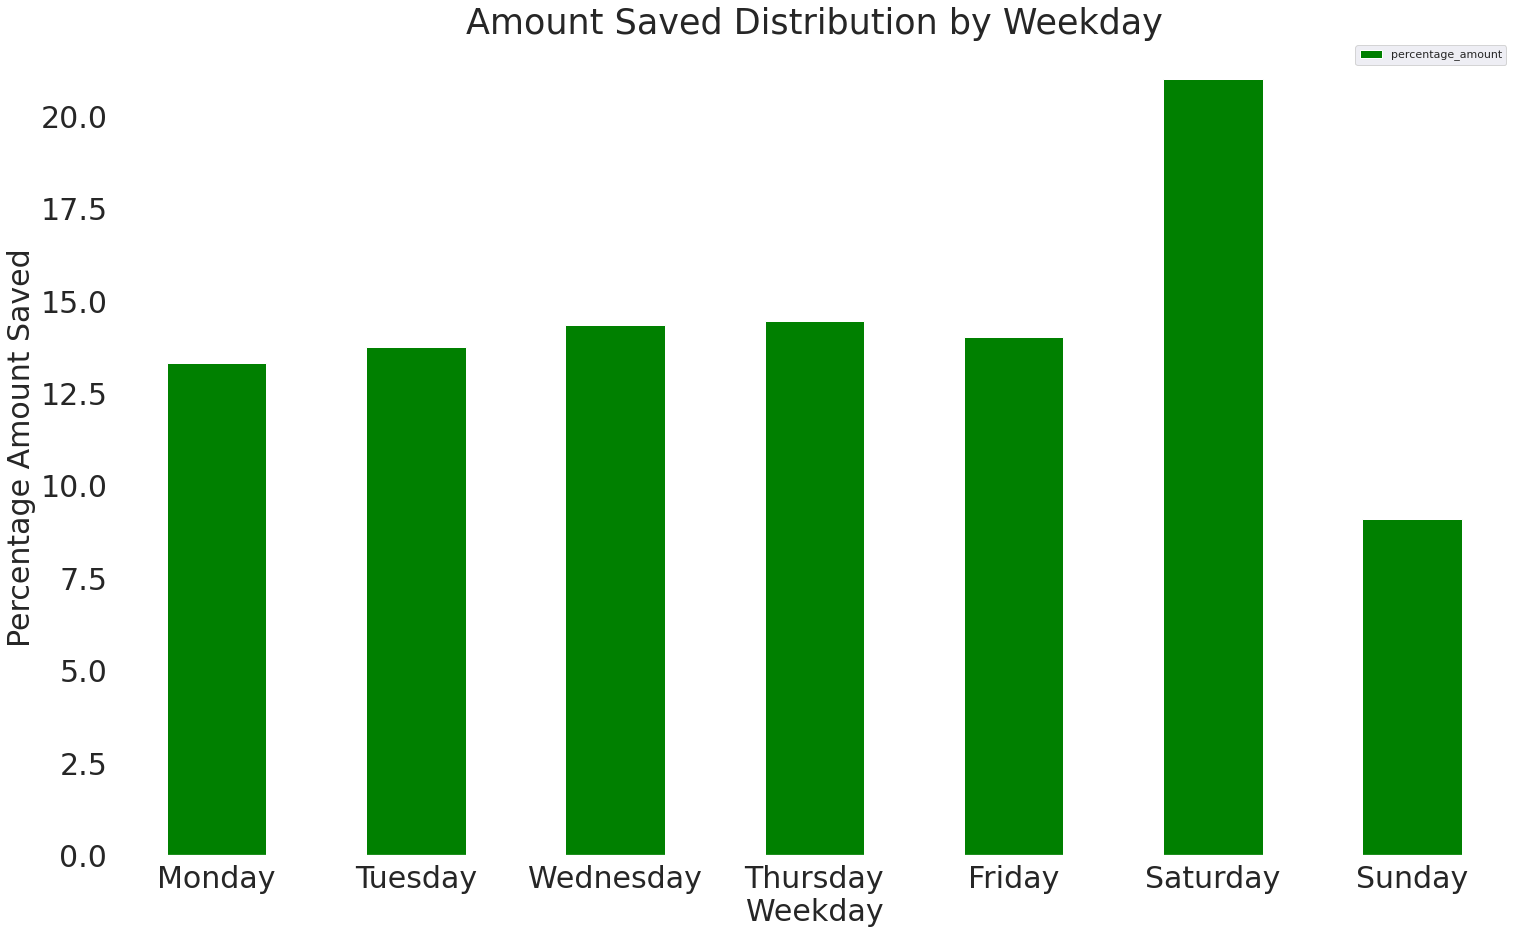

In [178]:
amount_savings_by_weekday = amount_savings_by_weekday.reset_index()


#Calclate percentages for Amount
amount_savings_by_weekday["percentage_amount"] = calculate_percentage(amount_savings_by_weekday["amount"])

plt = amount_savings_by_weekday.plot(kind = "bar", x = "weekday_saved", y = "percentage_amount", figsize = (25,15), 
                           rot = 0, fontsize = 30, color = "green")

plt.ticklabel_format(useOffset = False, style='plain', axis='y')
plt.set_title("Amount Saved Distribution by Weekday", fontsize = 35)
plt.set_xlabel("Weekday", fontsize = 30)
plt.set_ylabel("Percentage Amount Saved", fontsize = 30);
plt.set_facecolor("white")

plt.figure.savefig('plots/amount_savings_by_weekday.png', dpi=300)


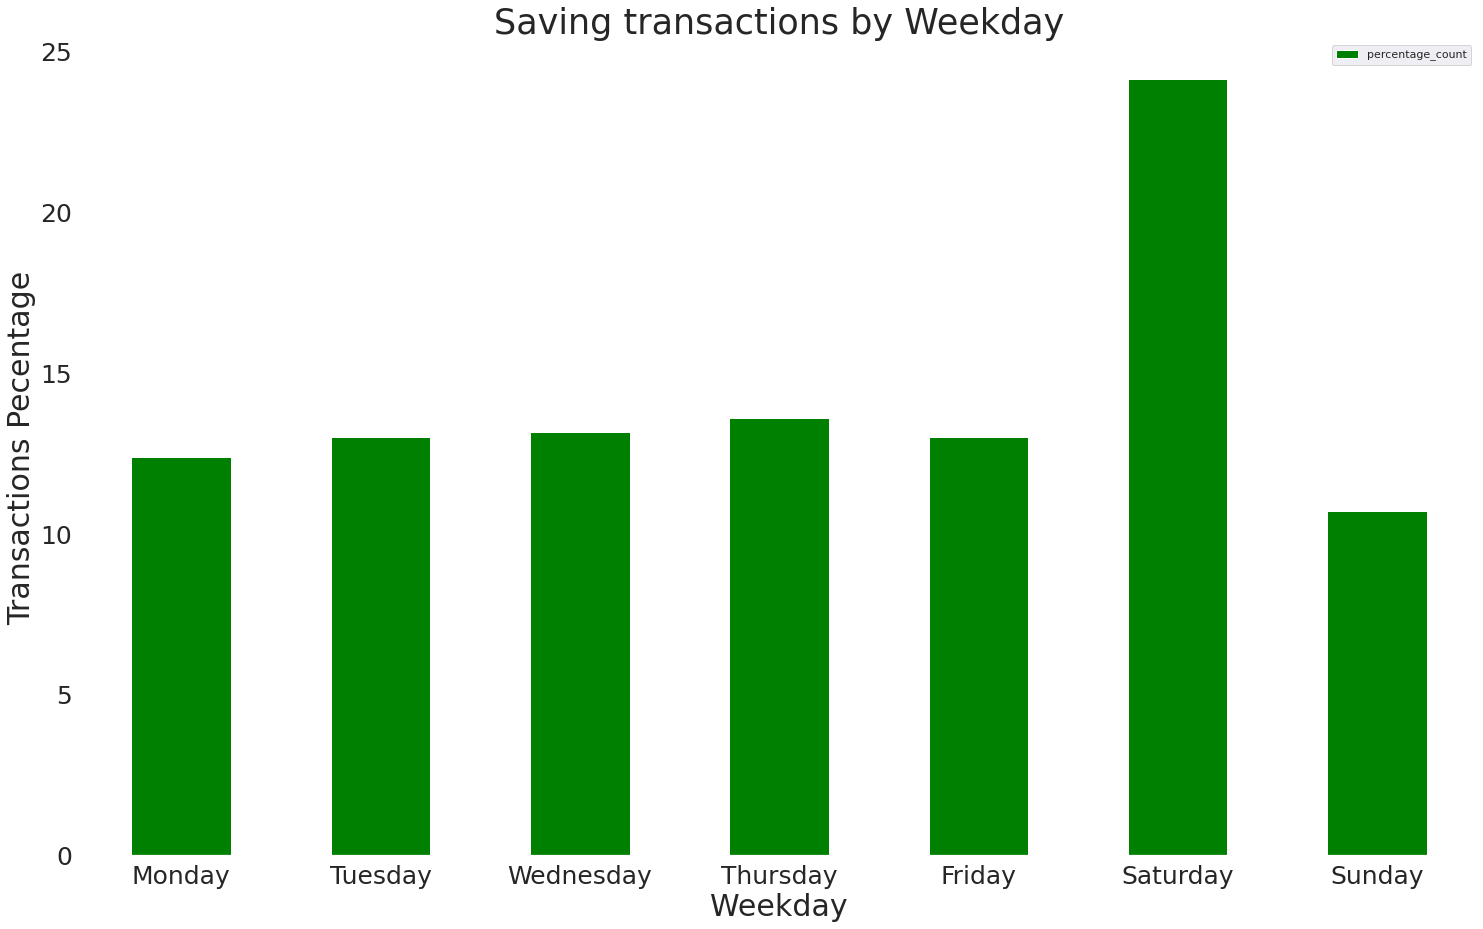

In [179]:
no_savings_by_weekday = no_savings_by_weekday.reset_index()

#get noof transactions percentage
no_savings_by_weekday["percentage_count"] = calculate_percentage(no_savings_by_weekday["size"])

plt = no_savings_by_weekday.plot(kind = "bar", x = "weekday_saved", y = "percentage_count", figsize = (25,15), 
                           rot = 0, fontsize = 25, color = "green")

plt.ticklabel_format(useOffset = False, style='plain', axis='y')
plt.set_title("Saving transactions by Weekday", fontsize = 35)
plt.set_xlabel("Weekday", fontsize = 30)
plt.set_ylabel("Transactions Pecentage", fontsize = 30)
plt.set_facecolor("white");

plt.figure.savefig('plots/no_savings_by_weekday.png', dpi=300)

#### Distribution of Savings over Month of year

In [139]:
#No of transactions by month of year
no_savings_by_month = savings_data.groupby('month_saved').size().to_frame('size')

#Amount saved by month of year
amount_savings_by_month = savings_data.groupby('month_saved')['amount'].sum()

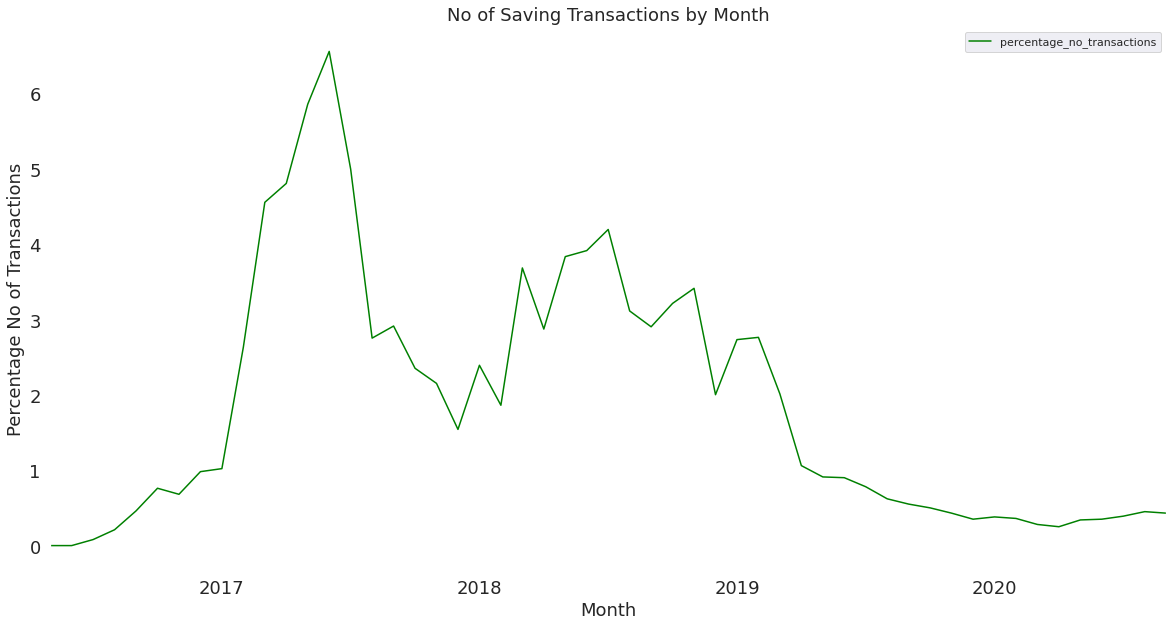

In [145]:
no_savings_by_month = savings_data.groupby('month_saved').size().to_frame('size').reset_index()

#Get No of tranactions percentage
no_savings_by_month ["percentage_no_transactions"] = calculate_percentage(no_savings_by_month['size'])


plt = no_savings_by_month.plot(kind = "line", x = "month_saved", y = "percentage_no_transactions", figsize = (20,10), 
                           rot = 0, fontsize = 18, color = "green")

plt.ticklabel_format(useOffset = False, style='plain', axis='y')
plt.set_title("No of Saving Transactions by Month", fontsize = 20)
plt.set_xlabel("Month", fontsize = 18)
plt.set_ylabel("Percentage No of Transactions", fontsize = 18)
plt.set_facecolor("white");


plt.figure.savefig('plots/no_savings_by_month.png', dpi=300)

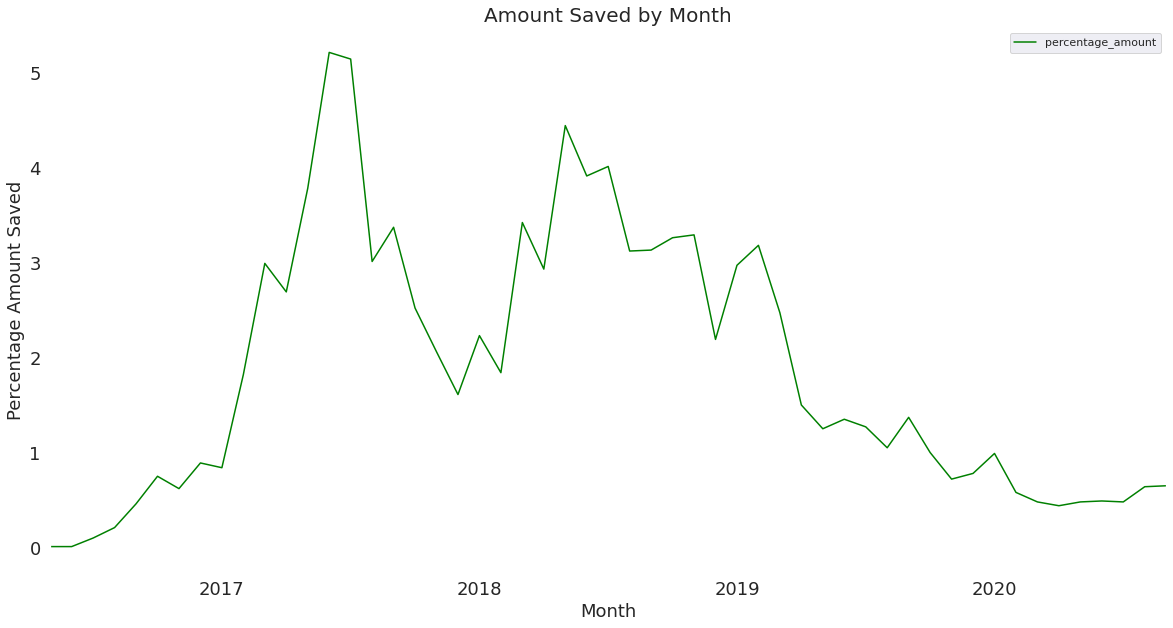

In [148]:
amount_savings_by_month = savings_data.groupby('month_saved')['amount'].sum().reset_index()

#Getting percentage
amount_savings_by_month ["percentage_amount"] = calculate_percentage(amount_savings_by_month["amount"])


plt = amount_savings_by_month.reset_index().plot(kind = "line", x = "month_saved", y = "percentage_amount", figsize = (20,10), 
                           rot = 0, fontsize = 18, color = "green")

plt.ticklabel_format(useOffset = False, style='plain', axis='y')
plt.set_title("Amount Saved by Month", fontsize = 20)
plt.set_xlabel("Month", fontsize = 18)
plt.set_ylabel("Percentage Amount Saved", fontsize = 18)
plt.set_facecolor("white");


plt.figure.savefig('plots/amount_savings_by_month.png', dpi=300)

##### Savings distributions over age groups


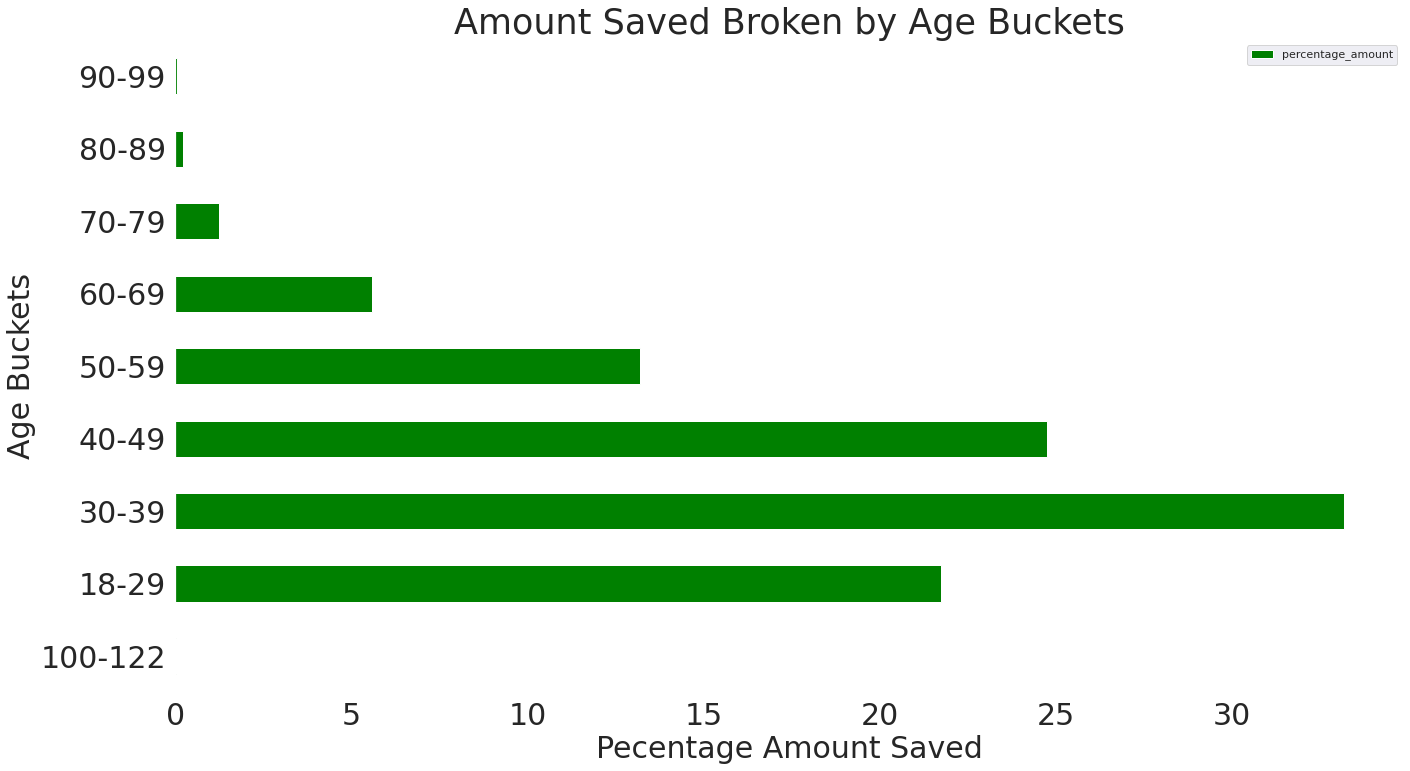

In [161]:
savings_by_age_bucket = savings_data.groupby("age_buckets")["amount"].sum().reset_index()

#Percentage Amount
savings_by_age_bucket['percentage_amount'] = calculate_percentage(savings_by_age_bucket['amount'])
 
plt = savings_by_age_bucket.plot(kind = "barh", x = "age_buckets", y = "percentage_amount", figsize = (22,12), 
                           rot = 0, fontsize = 30, color = "green")

plt.ticklabel_format(useOffset = False, style='plain', axis='x')
plt.set_title("Amount Saved Broken by Age Buckets", fontsize = 35)
plt.set_xlabel("Pecentage Amount Saved", fontsize = 30)
plt.set_ylabel("Age Buckets", fontsize = 30)
plt.set_facecolor("white");

plt.figure.savefig('plots/savings_by_age_bucket.png', dpi=300)

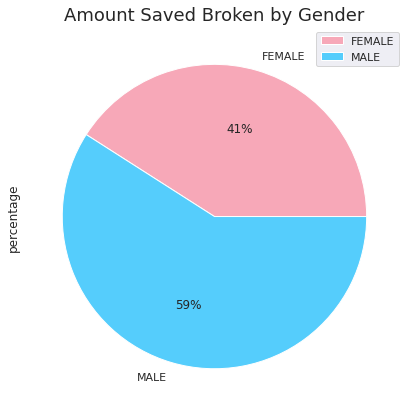

In [154]:

#Breacking down by gender
savings_gender = savings_data.groupby("gender_of_saver")["amount"].sum().reset_index()

savings_gender = savings_gender.set_index("gender_of_saver")

# Converting to Percentage
savings_gender['percentage'] = calculate_percentage(savings_gender["amount"])

#Plotting a pie chart
plt = savings_gender.plot(kind='pie', x = "gender_of_saver", y = "percentage", autopct="%.0f%%",
                    figsize = (7,7), colors = ['#F7A8B8' , '#55CDFC'])
plt.set_title("Amount Saved Broken by Gender", fontsize = 18)

plt.figure.savefig('plots/savings_gender.png', dpi=300)


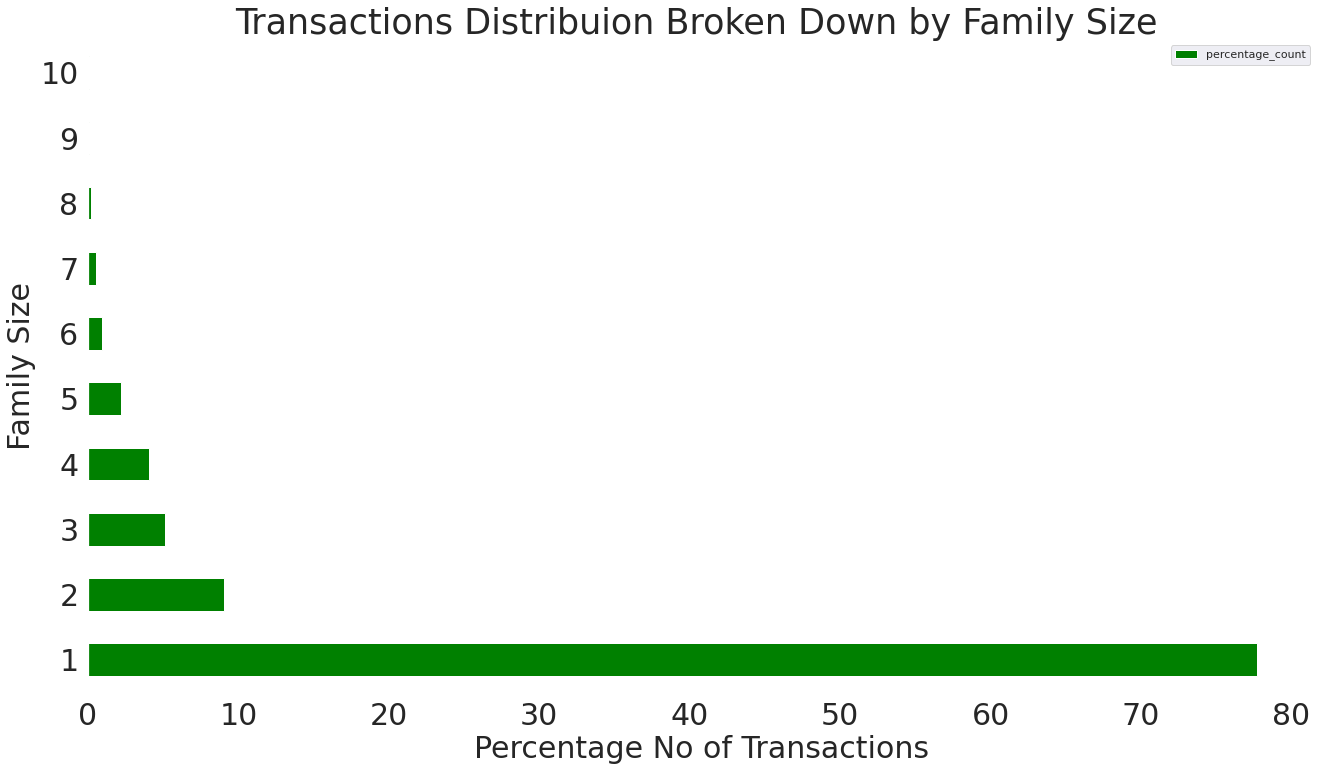

In [163]:
#group by family size
savings_by_family_size = savings_data.groupby("family_size").size().to_frame(name = "count").reset_index()

#Filter only family size less than 10
savings_by_family_size = savings_by_family_size[savings_by_family_size['family_size'] <= 10]

#Get Percentage Count
savings_by_family_size['percentage_count'] = calculate_percentage(savings_by_family_size['count'])

#Plot
plt = savings_by_family_size.reset_index().plot(kind = "barh", x = "family_size", y = "percentage_count", figsize = (22,12), 
                           rot = 0, fontsize = 30, color = "green")

plt.ticklabel_format(useOffset = False, style='plain', axis='x')
plt.set_title("Transactions Distribuion Broken Down by Family Size ", fontsize = 35)
plt.set_xlabel("Percentage No of Transactions", fontsize = 30)
plt.set_ylabel("Family Size", fontsize = 30)
plt.set_facecolor("white");

plt.figure.savefig('plots/savings_by_family_size.png', dpi=300)